### Assignment 4 
#### Question 3 Bagging
#### Amey Choudhary
#### 2021113017

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# initialising models. Some params from assignment 3
dtc = DecisionTreeClassifier()
dtr = DecisionTreeRegressor()
lr = LinearRegression()
logr = LogisticRegression(max_iter=1000)
mlpc = MLPClassifier(activation='relu', max_iter=1000, hidden_layer_sizes=(10,5), solver='sgd')
mlpr = MLPRegressor(activation='relu', max_iter=1000, hidden_layer_sizes=(10,5), solver='sgd')

#### Bagging Classifier

In [3]:
wine_dataset = pd.read_csv('../Datasets/WineQT.csv')
wine_dataset = wine_dataset.drop('Id', axis=1)
print(wine_dataset.head())
X_wine = wine_dataset.drop('quality', axis=1)
y_wine = wine_dataset['quality']

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [4]:
# defining a function to do bagging in classification

X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42)

def bagging_class(model, num_estimators, fraction, bootstrap, voting_mech):

    X_train_bag = []
    y_train_bag = []

    # formulating the train datasets
    for i in range(num_estimators):
        X_train_bag.append(X_train.sample(frac=fraction, replace=bootstrap))
        y_train_bag.append(y_train[X_train_bag[i].index])

    models = []
    # training the models
    for i in range(num_estimators):
        model.fit(X_train_bag[i], y_train_bag[i])
        models.append(model)

    # predicting the values

    if voting_mech == 'hard':
        y_pred = []
        for i in range(num_estimators):
            y_pred.append(models[i].predict(X_test))
        y_pred = np.array(y_pred)
        y_pred = np.round(np.mean(y_pred, axis=0)) # calculates the most frequent value
        return y_pred

    if voting_mech == 'soft':
        y_pred = []
        classes = np.unique(y_train)
        for i in range(num_estimators):
            y_pred.append(models[i].predict_proba(X_test))
        y_pred = np.array(y_pred)
        y_pred = np.mean(y_pred, axis=0)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = classes[y_pred]
        return y_pred

In [5]:
# checking the accuracy of the model for bagging
y_outcome = bagging_class(dtc, 10, 0.8, True, 'soft')
print(accuracy_score(y_test, y_outcome))

0.537117903930131


In [6]:
# checking the accuracies for different number of estimators, models and fractions

models = [dtc, logr, mlpc]
num_estimators = [1, 3, 5, 7, 10]
fractions = [0.15, 0.25, 0.5, 0.75, 1]
voting_mech = ['hard', 'soft']
bootstrap = [True, False]

accuracies_matrix = np.zeros((len(models), len(num_estimators), len(fractions)))

for model in models:
    for num_estimator in num_estimators:
        for fraction in fractions:
            boot = True
            vote = 'hard'
            y_outcome = bagging_class(model, num_estimator, fraction, boot, vote)
            accuracies_matrix[models.index(model), num_estimators.index(num_estimator), fractions.index(fraction)] = accuracy_score(y_test, y_outcome)
            # print('Model: ', model, 'Num Estimators: ', num_estimator, 'Fraction: ', fraction, 'Voting Mechanism: ', vote, 'Bootstrap: ', boot, 'Accuracy: ', accuracy_score(y_test, y_outcome))

/home/ameychoudhary4/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ameychoudhary4/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

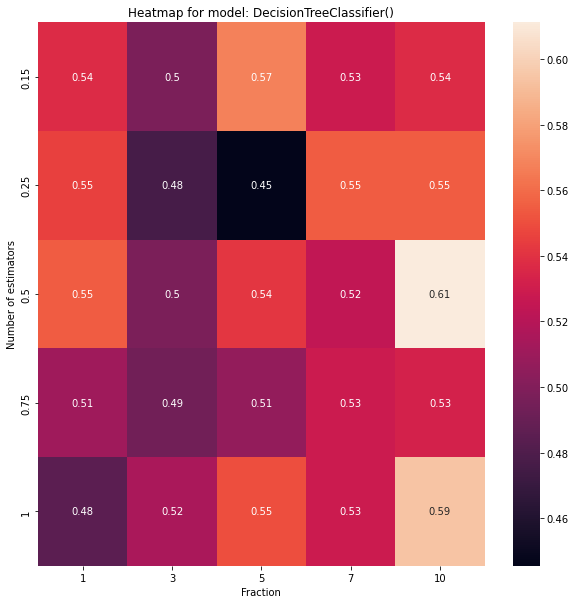

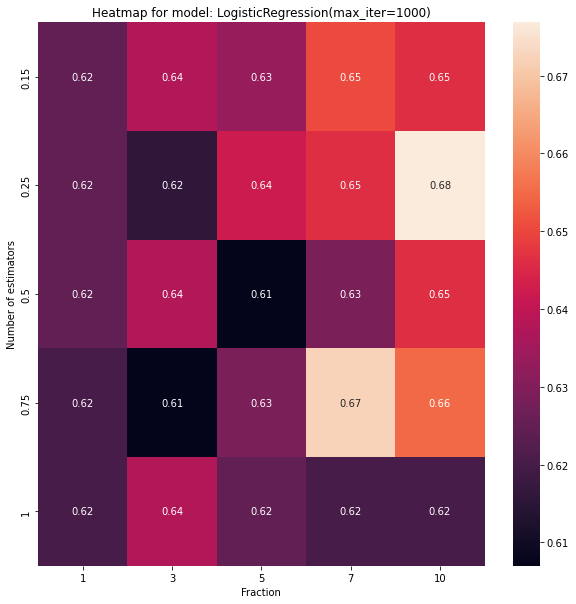

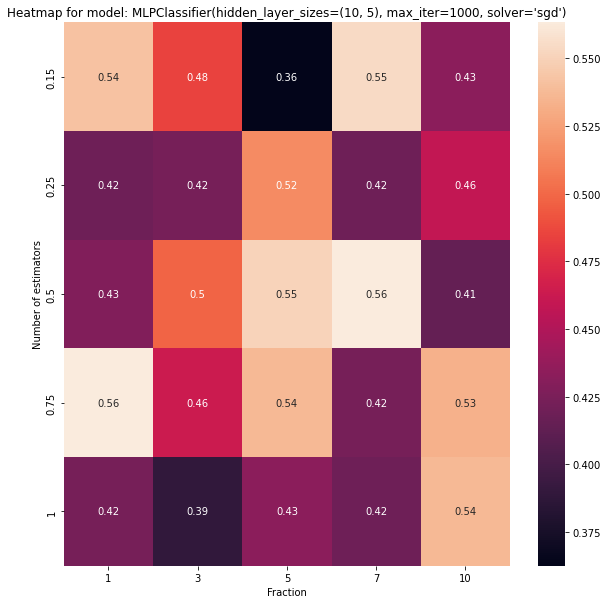

In [7]:
# make the heatmap for particular models
for model in models:
    plt.figure(figsize=(10, 10))
    sns.heatmap(accuracies_matrix[models.index(model), :, :], annot=True, xticklabels=num_estimators, yticklabels=fractions)
    plt.title('Heatmap for model: ' + str(model))
    plt.xlabel('Fraction')
    plt.ylabel('Number of estimators')
    plt.show()

In [8]:
# finding the best ensemble for each model
best_params_matrix = []

for model in models:
    best_params = []
    for i in range(len(num_estimators)):
        for j in range(len(fractions)):
            if accuracies_matrix[models.index(model), i, j] == np.max(accuracies_matrix[models.index(model), :, :]):
                best_params.append(num_estimators[i])
                best_params.append(fractions[j])
                break
        if len(best_params) != 0:
            break
    best_params_matrix.append(best_params)

print('Best params matrix: ', best_params_matrix)

acc_normal = [] 
acc_best = []

for model in models:
    y_pred_normal = bagging_class(model, 1, 1, False, 'hard') # normal model
    acc_normal.append(accuracy_score(y_test, y_pred_normal))
    y_pred_best = bagging_class(model, best_params_matrix[models.index(model)][0], best_params_matrix[models.index(model)][1], True, 'hard') # best model
    acc_best.append(accuracies_matrix[models.index(model), num_estimators.index(best_params_matrix[models.index(model)][0]), fractions.index(best_params_matrix[models.index(model)][1])])
    # print('Model: ', model, 'Normal Accuracy: ', acc_normal, 'Best Accuracy: ', acc_best)


Best params matrix:  [[5, 1], [3, 1], [5, 0.75]]


/home/ameychoudhary4/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ameychoudhary4/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

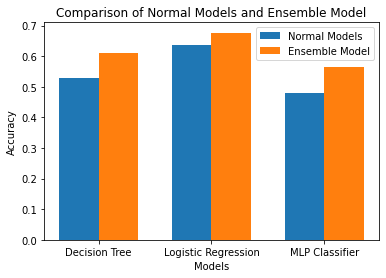

In [9]:
# Chatgpt for code generation of histograms

# Example data (replace these with your actual accuracy arrays)
normal_model_accuracies = np.array(acc_normal)
ensemble_model_accuracies = np.array(acc_best)

# Plotting the histograms side by side
fig, ax = plt.subplots()

# Set the bar width
bar_width = 0.35

# Set the positions for the bars on X-axis
index = np.arange(len(normal_model_accuracies))

# Plot the normal model accuracies
bar1 = ax.bar(index, normal_model_accuracies, bar_width, label='Normal Models')

# Plot the ensemble model accuracies next to the normal models
bar2 = ax.bar(index + bar_width, ensemble_model_accuracies, bar_width, label='Ensemble Model')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Normal Models and Ensemble Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Decision Tree', 'Logistic Regression', 'MLP Classifier'))
ax.legend()

# Display the plot
plt.show()


#### Bagging Regressor 

In [10]:
# getting the dataset
boston_dataset = pd.read_csv('../Datasets/HousingData.csv')
boston_dataset = boston_dataset.dropna()

# normalising the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
boston_dataset = pd.DataFrame(scaler.fit_transform(boston_dataset), columns=boston_dataset.columns)
print(boston_dataset.head())

       CRIM    ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0  0.000000  0.18  0.067815   0.0  0.309129  0.577505  0.641607  0.269203   
1  0.000236  0.00  0.242302   0.0  0.165975  0.547998  0.782698  0.348962   
2  0.000236  0.00  0.242302   0.0  0.165975  0.694386  0.599382  0.348962   
3  0.000293  0.00  0.063050   0.0  0.143154  0.658555  0.441813  0.448545   
4  0.000264  0.00  0.063050   0.0  0.143154  0.549722  0.574665  0.448545   

        RAD       TAX   PTRATIO         B     LSTAT      MEDV  
0  0.000000  0.208015  0.287234  1.000000  0.089680  0.422222  
1  0.043478  0.104962  0.553191  1.000000  0.204470  0.368889  
2  0.043478  0.104962  0.553191  0.989678  0.063466  0.660000  
3  0.086957  0.066794  0.648936  0.994243  0.033389  0.631111  
4  0.086957  0.066794  0.648936  0.992950  0.096026  0.526667  


In [11]:
X = boston_dataset.drop('MEDV', axis=1)
y = boston_dataset['MEDV']

In [12]:
# defining the regression function of bagging

from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

def bagging_reg(model, num_estimators, fraction, bootstrap, voting_mech):

    X_train_bag = []
    y_train_bag = []

    # formulating the train datasets
    for i in range(num_estimators):
        X_train_bag.append(X_train.sample(frac=fraction, replace=bootstrap))
        y_train_bag.append(y_train[X_train_bag[i].index])

    models = []
    # training the models
    for i in range(num_estimators):
        model.fit(X_train_bag[i], y_train_bag[i])
        models.append(model)

    # predicting the values

    if voting_mech == 'hard':
        y_pred = []
        for i in range(num_estimators):
            y_pred.append(models[i].predict(X_test))
        y_pred = np.array(y_pred)
        y_pred = np.mean(y_pred, axis=0) # calculates the mean value
        return y_pred
    
    if voting_mech == 'soft':
        confidences = []
        for i in range(num_estimators):
            y = models[i].predict(X_val)
            # calculating the mse 
            mse = mean_squared_error(y_val, y)
            confidences.append(1/mse)
        confidences = np.array(confidences)
        index = np.argmax(confidences)
        y_pred = models[index].predict(X_test)
        return y_pred



In [13]:
# running the bagging function for regression on one model
y_pred = bagging_reg(dtr, 10, 0.8, True, 'hard')
print(mean_squared_error(y_test, y_pred))


0.019628379434286608


In [14]:
# running on different models and different parameters
models = [dtr, lr, mlpr]
num_estimators = [1, 3, 5, 7, 10]
fractions = [0.15, 0.25, 0.5, 0.75, 1]
voting_mech = ['hard', 'soft']
bootstrap = [True, False]

mse_matrix = np.zeros((len(models), len(num_estimators), len(fractions)))

for model in models:
    for num_estimator in num_estimators:
        for fraction in fractions:
            boot = True
            vote = 'hard'
            y_outcome = bagging_reg(model, num_estimator, fraction, boot, vote)
            mse_matrix[models.index(model), num_estimators.index(num_estimator), fractions.index(fraction)] = mean_squared_error(y_test, y_outcome)
            # print('Model: ', model, 'Num Estimators: ', num_estimator, 'Fraction: ', fraction, 'Voting Mechanism: ', vote, 'Bootstrap: ', boot, 'Accuracy: ', accuracy_score(y_test, y_outcome))

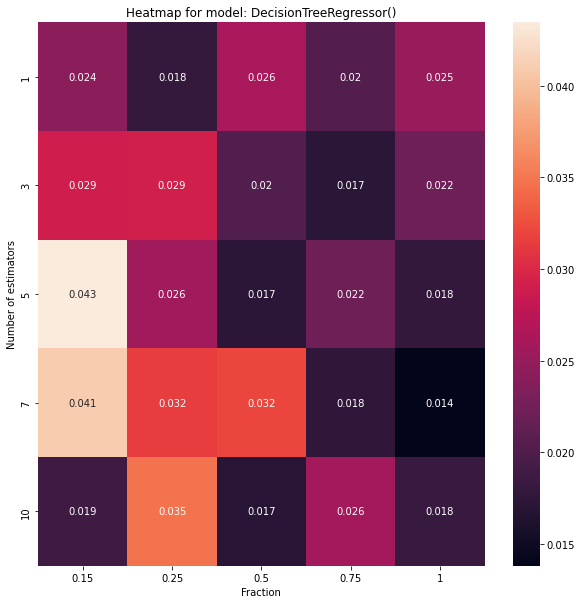

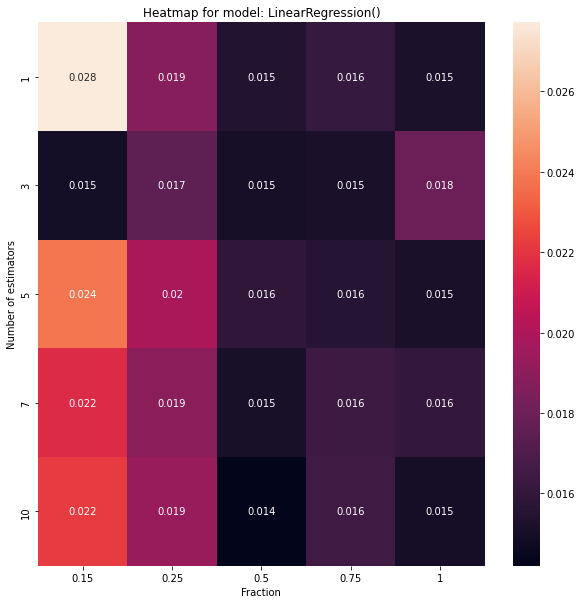

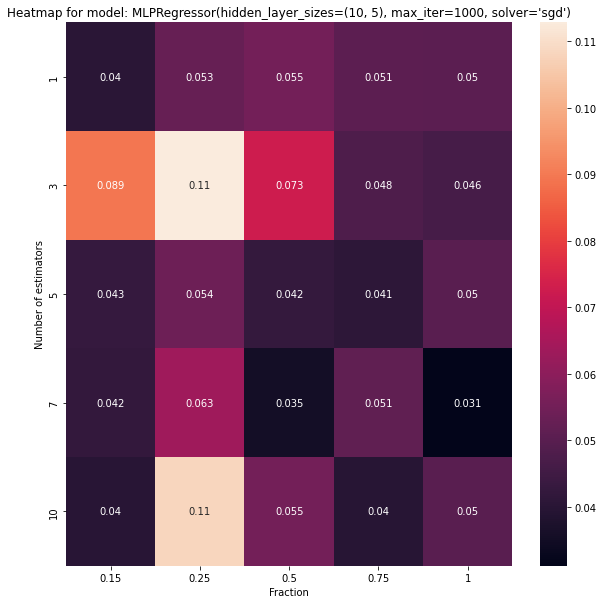

In [15]:
#  makinn the heatmap for particular models
for model in models:
    plt.figure(figsize=(10, 10))
    sns.heatmap(mse_matrix[models.index(model), :, :], annot=True, xticklabels=fractions, yticklabels=num_estimators)
    plt.title('Heatmap for model: ' + str(model))
    plt.xlabel('Fraction')
    plt.ylabel('Number of estimators')
    plt.show()

In [16]:
# finding the best ensemble for each model
best_params_matrix = []

for model in models:
    best_params = []
    for i in range(len(num_estimators)):
        for j in range(len(fractions)):
            if mse_matrix[models.index(model), i, j] == np.min(mse_matrix[models.index(model), :, :]):
                best_params.append(num_estimators[i])
                best_params.append(fractions[j])
                break
        if len(best_params) != 0:
            break
    best_params_matrix.append(best_params)

print('Best params matrix: ', best_params_matrix)

mse_normal = []
mse_best = []

for model in models:
    y_pred_normal = bagging_reg(model, 1, 1, False, 'hard') # normal model
    mse_normal.append(mean_squared_error(y_test, y_pred_normal))
    y_pred_best = bagging_reg(model, best_params_matrix[models.index(model)][0], best_params_matrix[models.index(model)][1], True, 'hard') # best model
    mse_best.append(mse_matrix[models.index(model), num_estimators.index(best_params_matrix[models.index(model)][0]), fractions.index(best_params_matrix[models.index(model)][1])])
    # print('Model: ', model, 'Normal Accuracy: ', acc_normal, 'Best Accuracy: ', acc_best)

Best params matrix:  [[7, 1], [10, 0.5], [7, 1]]


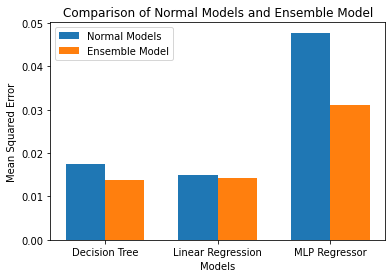

In [17]:
# plotting the histograms for the regression models

normal_mode_mse = np.array(mse_normal)
ensemble_model_mse = np.array(mse_best)

# Plotting the histograms side by side
fig, ax = plt.subplots()

# Set the bar width
bar_width = 0.35

# Set the positions for the bars on X-axis
index = np.arange(len(normal_mode_mse))

# Plot the normal model accuracies
bar1 = ax.bar(index, normal_mode_mse, bar_width, label='Normal Models')

# Plot the ensemble model accuracies next to the normal models
bar2 = ax.bar(index + bar_width, ensemble_model_mse, bar_width, label='Ensemble Model')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of Normal Models and Ensemble Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Decision Tree', 'Linear Regression', 'MLP Regressor'))
ax.legend()

# Display the plot
plt.show()

#### Bagging: 
We can see that bagging increases the accuracies of all models (Classification) and decreases the mse of all  models (Regression). This is because bagging is a method of combining the results of multiple models trained on different subsets of the data set. It reduces the variance of the model and hence reduces overfitting.